In [1]:
#Read training data
import pandas as pd
fileName = "trainData.csv"
df = pd.read_csv(fileName, sep = ',')

In [2]:
df.head()

,ID,O,C,H,L,V,BV,Mean,T,MarketName,Reward
0,1,0.015275,-0.023044,-0.002150,-0.016174,0.419006,0.411878,-0.008966,2015-12-15,BTC-ETH,-0.896561
1,1,-0.036503,0.001192,0.040730,-0.032838,0.500554,0.485358,0.005236,2015-12-16,BTC-ETH,0.523557
2,1,0.015463,-0.063636,-0.078651,-0.048164,-0.394836,-0.423502,-0.064499,2015-12-17,BTC-ETH,-6.449900
3,1,-0.063636,-0.041748,-0.068826,-0.005056,-0.407574,-0.437244,-0.038707,2015-12-18,BTC-ETH,-3.870695
4,1,-0.041748,-0.009620,-0.030636,-0.032878,0.105960,0.092657,-0.031732,2015-12-19,BTC-ETH,-3.173201


In [3]:
colnames = ['T','O','C','H','L','V','BV']
reward_cols = ['T','Reward']

In [4]:
eth = df[(df['MarketName'] == 'BTC-ETH')][colnames]
xrp = df[(df['MarketName'] == 'BTC-XRP')][colnames]
ltc = df[(df['MarketName'] == 'BTC-LTC')][colnames]
xlm = df[(df['MarketName'] == 'BTC-XLM')][colnames]
usd = df[(df['MarketName'] == 'USDT-BTC')][colnames]

In [5]:
eth.head()

,T,O,C,H,L,V,BV
0,2015-12-15,0.015275,-0.023044,-0.002150,-0.016174,0.419006,0.411878
1,2015-12-16,-0.036503,0.001192,0.040730,-0.032838,0.500554,0.485358
2,2015-12-17,0.015463,-0.063636,-0.078651,-0.048164,-0.394836,-0.423502
3,2015-12-18,-0.063636,-0.041748,-0.068826,-0.005056,-0.407574,-0.437244
4,2015-12-19,-0.041748,-0.009620,-0.030636,-0.032878,0.105960,0.092657


In [6]:
eth_reward = df[(df['MarketName'] == 'BTC-ETH')][reward_cols]
xrp_reward = df[(df['MarketName'] == 'BTC-XRP')][reward_cols]
ltc_reward = df[(df['MarketName'] == 'BTC-LTC')][reward_cols]
xlm_reward = df[(df['MarketName'] == 'BTC-XLM')][reward_cols]
usd_reward = df[(df['MarketName'] == 'USDT-BTC')][reward_cols]
usd_reward.loc[:,'Reward'] *= -1 # Because we used tether reward

In [7]:
eth_reward.head()

,T,Reward
0,2015-12-15,-0.896561
1,2015-12-16,0.523557
2,2015-12-17,-6.449900
3,2015-12-18,-3.870695
4,2015-12-19,-3.173201


In [8]:
merged1 = pd.merge(eth, xrp, on = 'T', suffixes=('_eth', '_xrp'))
merged2 = pd.merge(ltc, xlm, on = 'T', suffixes=('_ltc', '_xlm'))
merged = pd.merge(merged1, merged2, on = 'T')
merged = pd.merge(merged, usd, on = 'T')
merged.head()

,T,O_eth,C_eth,H_eth,L_eth,V_eth,BV_eth,O_xrp,C_xrp,H_xrp,...,H_xlm,L_xlm,V_xlm,BV_xlm,O,C,H,L,V,BV
0,2015-12-15,0.015275,-0.023044,-0.002150,-0.016174,0.419006,0.411878,-0.250256,-0.100416,-0.212046,...,-0.043933,-0.144351,1029.180334,885.502597,0.000000,0.071429,0.071429,0.000000,1320.637261,1410.396749
1,2015-12-16,-0.036503,0.001192,0.040730,-0.032838,0.500554,0.485358,-0.111491,0.131640,-0.027795,...,-0.052516,0.000000,-0.521941,-0.507073,0.071429,0.002222,0.044444,0.071429,-0.815032,-0.810448
2,2015-12-17,0.015463,-0.063636,-0.078651,-0.048164,-0.394836,-0.423502,0.131640,-0.024490,-0.025341,...,-0.055427,0.000000,-0.992587,-0.992851,0.071429,0.002222,0.044444,0.071429,-0.815032,-0.810448
3,2015-12-18,-0.063636,-0.041748,-0.068826,-0.005056,-0.407574,-0.437244,-0.040816,-0.056485,-0.054000,...,0.058680,0.019560,1.314162,1.401100,0.020000,0.017738,-0.023404,0.020000,-0.999841,-0.999841
4,2015-12-19,-0.041748,-0.009620,-0.030636,-0.032878,0.105960,0.092657,-0.036879,-0.002956,-0.038055,...,-0.053118,-0.098321,11.826813,10.635375,-0.017429,-0.017429,-0.017429,-0.017429,863.027096,847.967800


# REINFORCEMENT LEARNING SETTINGS

In [9]:
import random
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.preprocessing import MinMaxScaler
from random import randint

Using TensorFlow backend.


In [36]:
EPISODES = 2

class TradingAction(object):
    ETH = 0
    XRP = 1
    LTC = 2
    XLM = 3
    USD = 4
    BTC = 5
    
class TradingEnv:
  def __init__(self):
    #Actions : 0. eth, 1. xrp, 2. ltc, 3. xlm, 4. usd, 5. btc
    pass

  def reset(self):
    pass

  def __init__(self):
    #Actions : 0. eth, 1. xrp, 2. ltc, 3. xlm, 4. usd, 5. btc
    pass

  def step(self, action, date):
    reward = 0
    if action == TradingAction.ETH:
        reward = eth_reward[(eth_reward['T'] == date)]['Reward']
    if action == TradingAction.XRP:
        reward = xrp_reward[(xrp_reward['T'] == date)]['Reward']
    if action == TradingAction.LTC:
        reward = ltc_reward[(ltc_reward['T'] == date)]['Reward']
    if action == TradingAction.XLM:
        reward = xlm_reward[(xlm_reward['T'] == date)]['Reward']
    if action == TradingAction.USD:
        reward = usd_reward[(usd_reward['T'] == date)]['Reward']
    if action == TradingAction.BTC:
        reward = 0 # Do nothing action
    return reward

In [47]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            '''
            if not done:
                temp_pred = np.amax(self.model.predict(next_state)[0])
                target = (reward + self.gamma * temp_pred)
                target = target.item()
            '''
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [48]:
#Split as Train and Test data
row_count = merged.shape[0]
split_point = int(row_count - 60)
train_data, test_data = merged[:split_point], merged[split_point:]
test_data.head()

,T,O_eth,C_eth,H_eth,L_eth,V_eth,BV_eth,O_xrp,C_xrp,H_xrp,...,H_xlm,L_xlm,V_xlm,BV_xlm,O,C,H,L,V,BV
1189,2019-03-18,-0.010824,-0.007006,0.000082,-0.005069,0.735506,0.732216,-0.003021,-0.004671,-0.003263,...,0.086560,-0.003357,5.939176,6.270275,-0.005429,0.002605,0.005369,0.001904,0.878755,0.879482
1190,2019-03-19,-0.008638,-0.000860,-0.010302,0.000862,-0.242948,-0.247808,-0.005050,-0.002156,-0.006422,...,-0.001681,0.034431,-0.426080,-0.424562,0.001601,0.004968,0.000365,0.003223,-0.426543,-0.424743
1191,2019-03-20,-0.000039,-0.003951,-0.008330,-0.008638,-0.063724,-0.068058,-0.001903,-0.001144,0.012546,...,-0.053872,-0.028582,-0.321484,-0.342432,0.006122,0.007443,0.003994,0.003877,0.153287,0.159204
1192,2019-03-21,-0.004292,-0.015139,-0.002748,-0.011451,0.323505,0.315041,-0.000890,-0.010308,-0.013517,...,-0.032028,-0.051024,-0.022323,-0.063149,0.006040,-0.015198,0.002972,-0.018895,0.765888,0.755553
1193,2019-03-22,-0.014801,0.007919,-0.004498,-0.000200,-0.207166,-0.209078,-0.010434,0.000000,-0.008627,...,0.009926,0.029042,-0.383236,-0.371657,-0.014622,0.001982,-0.013914,0.014609,-0.455185,-0.455566


In [49]:
#TRAIN AGENT
observation_cols = ['O_eth','C_eth','H_eth','L_eth','V_eth','BV_eth','O_xrp','C_xrp','H_xrp','L_xrp','V_xrp','BV_xrp','O_ltc','C_ltc','H_ltc','L_ltc','V_ltc','BV_ltc','O_xlm','C_xlm','H_xlm','L_xlm','V_xlm','BV_xlm','O','C','H','L','V','BV']
state_size = len(observation_cols)
action_size = 6 #Actions : 0. eth, 1. xrp, 2. ltc, 3. xlm, 4. usd, 5. btc
env = TradingEnv()
agent = DQNAgent(state_size, action_size)
# agent.load("./save/trading-dqn.h5")

done = False
batch_size = 32
best_score = 0
best_action = 0
best_reward = -100000

for e in range(EPISODES):
    total_reward = 0
    for idx in range(len(train_data)-1):
        state = train_data.iloc[idx][observation_cols]
        state = np.reshape([state], [1, state_size])
        
        action = agent.act(state)
        reward = env.step(action, train_data.iloc[idx+1]['T'])
        
        next_state = train_data.iloc[idx+1][observation_cols]
        next_state = np.reshape([next_state], [1, state_size])
        
        if isinstance(reward, int) == False:
            reward = reward.item()
            
        agent.remember(state, action, reward, next_state, done)
        total_reward = total_reward + reward
        if total_reward >= best_reward:
            best_reward = total_reward
            best_action = action
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    print("episode: {}, best_reward: {}, total_reward: {}" .format(e, best_reward, total_reward))


episode: 0, best_reward: 859.1372461008665, total_reward: 858.6529198326572
episode: 1, best_reward: 2062.5976539571475, total_reward: 2062.113327688938


In [18]:
#Save Agent
agent.save("./save/trading-dqn.h5")

In [52]:
#TEST AGENT
done = False
batch_size = 32
test_reward = 0
reward_list = []
for idx in range(len(test_data)-1):
    state = test_data.iloc[idx][observation_cols]
    state = np.reshape([state], [1, state_size])

    action = agent.act(state)
    reward = env.step(action, test_data.iloc[idx+1]['T'])
    if isinstance(reward, int) == False:
        reward = reward.item()
    test_reward = test_reward + reward 
    reward_list.append(reward)
print("Test_reward: {}" .format(test_reward))

Test_reward: 12.633406988082006


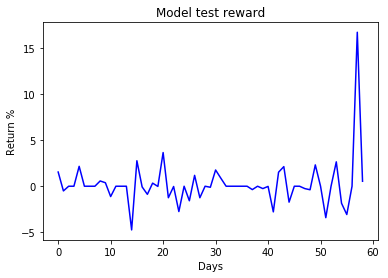

In [53]:
#Plot rewards
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(0,len(test_data)-1,1),reward_list, c='b')
plt.title('Model test reward')
plt.ylabel('Return %')
plt.xlabel('Days')
plt.show()

In [55]:
print(merged.iloc[-1]['T'])
state = merged.iloc[-1][observation_cols]
state = np.reshape([state], [1, state_size])
act_values = agent.model.predict(state)
print(act_values)
print("Best action",np.argmax(act_values[0]))
print("Best reward",np.max(act_values[0]))
#Actions : 0. eth, 1. xrp, 2. ltc, 3. xlm, 4. usd, 5. btc

2019-05-16
[[ 3.0685585   0.40643653 -0.37692785  7.0248303   2.479444   -0.5465276 ]]
Best action 3
Best reward 7.0248303
